# Kvadratur-metodar

## Adaptiv Simpson-kvadratur

In [15]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp

# pretty-print sympy things
sp.init_printing()

# nice big latex-flavored plots
# if you don't have these fonts, or you don't have
# XeLaTeX installed, this needs to be modified.
fontsize = 20
newparams = {
    'axes.titlesize': fontsize,
    'axes.labelsize': fontsize,
    'lines.linewidth': 2, 
    'lines.markersize': 7,
    'font.family': "serif",
    'text.usetex': True,
    "pgf.texsystem": "xelatex",
    "pgf.rcfonts": False,
    "pgf.preamble": [
        r"\usepackage{unicode-math}",
        r"\setmainfont{EB Garamond}",
        r"\setmonofont{Courier New}",
        r"\setmathfont[StylisticSet={2,7,10}]{Garamond-Math}",
    ],
    'figure.figsize': (16,9), 
    'ytick.labelsize': fontsize,
    'xtick.labelsize': fontsize,
    'legend.fontsize': fontsize,
    'legend.handlelength': 1.5,
    'xtick.major.pad': 8,
    'ytick.major.pad': 8,
}

# !!!
# for some reason, on some machines, you need to run this cell twice
# it probably has something to do with python versions or something
# !!!
%matplotlib inline

# makes mpl use the pgf-renderer. sometimes (but not on all machines)
# this disables rendering in the notebook.
# if this happens on your machine, maybe use
# another backend while working, and switch
# to pgf when you want to generate the final plots.
mpl.use('pgf')

# right angles never hurt anyone,
# so use classic as a base theme
plt.style.use('classic')
# the gray border is not visible in the plot rendered
# by plt.savefig, so dont't  worry about that

# finally change the necessary parameters
plt.rcParams.update(newparams)

In [2]:
def S(f, a, b):
    return (f(a) + 4 * f((a + b) / 2) + f(b))  \
         * (b - a) / 6

def asm_quad(f, a, b, tol=1e-5):
    I0 = S(f, a, b)
    c = (a + b) / 2
    
    I = S(f, a, c) + S(f, c, b) 
    err = abs(I - I0) / 15
    
    if err < tol:
        return I + (I - I0) / 15
    else:
        return asm_quad(f, a, c, tol=tol/2)  \
             + asm_quad(f, c, b, tol=tol/2)

### Testar

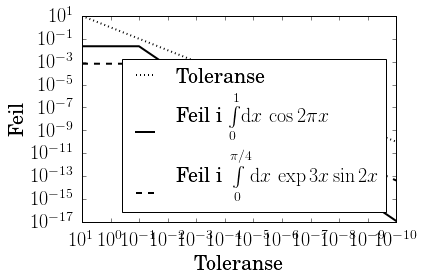

In [3]:
x = sp.symbols('x')

### first test
f = sp.cos(2 * sp.pi * x)
F = sp.integrate(f)
# make python function versions
fa = sp.lambdify(x, f)
Fa = sp.lambdify(x, F)

aa, ba = 0, 1
Ia = Fa(ba) - Fa(aa) # = 0

### second test
f = sp.exp(3 * x) * sp.sin(2 * x)
F = sp.integrate(f)
# make python function versions
fb = sp.lambdify(x, f)
Fb = sp.lambdify(x, F)

ab, bb = 0, np.pi/4
Ib = Fb(bb) - Fb(ab)

tols = np.linspace(10, 1e-10, 100)
errsa = np.array([abs(asm_quad(fa, aa, ba, tol=t) - Ia) for t in tols])
errsb = np.array([abs(asm_quad(fb, ab, bb, tol=t) - Ib) for t in tols])

plt.plot(tols, tols,  'k:',  label="Toleranse")
plt.plot(tols, errsa, 'k',   label="Feil i $\int\limits_0^1 \! \mathrm dx \, \cos 2 \pi x$")
plt.plot(tols, errsb, 'k--', label="Feil i $\int\limits_0^{\pi/4} \! \mathrm dx \, \exp 3 x \sin 2x$")

plt.xscale('log')
plt.yscale('log')

plt.ylabel("Feil")
plt.xlabel("Toleranse")

plt.xlim(tols[0], tols[-1])
plt.legend(loc="best")

plt.savefig("simp_err.pdf", bbox_inches = 'tight', pad_inches = 0)

plt.tight_layout()

In [4]:
asm_quad(fb, 0, np.pi/4, tol=1e-10), asm_quad(fa, 0, 1, tol=1e-10)

## Romberg-kvadratur

Eg brukar dette trikset for å spare litt minne:

In [5]:
R = np.array([[1, 2, 3], [3, 4, 5]])
Rp, Rn = 0, 1

R[Rn, :] = 9
Rp, Rn = Rn, Rp # (1)
R[Rn, :] = 8
print(R)

[[8 8 8]
 [9 9 9]]


Og lagrar kun to rader i gongen. Vi kan bruke (1)
til å bytte radene. Til eit kvart tidspunkt er
${\tt R[Rn, j]} = R(n, j)$ og ${\tt R[Rp, j]} = R(n - 1, j)$.
Når vi er ferdig med ein iterasjon byttar vi om på "peikarane",
slik at `Rn` blir `Rp`, og skriv over verdiane frå to iterasjonar
tilbake i i staden for å allokere minne for heile matrisa.

In [6]:
def romberg(f, a, b, MAX_ITER=100, tol=1e-5):
    R = np.zeros((2, MAX_ITER))
    Rp, Rn = 0, 1
    
    h = b - a 
    R[Rp, 0] = 0.5 * h * (f(a) + f(b))
    
    for n in range(1, MAX_ITER):
        h = h * 0.5
        L = np.linspace(a + h, b - h, 1 << n - 1)
        R[Rn, 0] = 0.5 * R[Rp, 0] + h * np.sum(f(L))
        
        for k in range(1, n + 1):
            E = (R[Rn, k - 1] - R[Rp, k - 1]) / ((1 << 2 * k) - 1)
            R[Rn, k] = R[Rn, k - 1] + E
                
        Rp, Rn = Rn, Rp
        
        if abs(E) < tol:
            break
    
    return R[Rp, n]

### Test
For å teste algoritma forsøker eg å evaluere gauss-integralet.

In [7]:
def gauss(x): return 2/np.sqrt(np.pi) * np.exp(-x**2)

erf1_exact = 0.842700792949714869341220635082609259296066997966302908459

erf1 = romberg(gauss, 0, 1, tol=1e-10)
erf1, abs(erf1 - erf1_exact)

In [8]:
def f(x): return np.cos(2 * np.pi * x)
def g(x): return x**(1/3)

In [9]:
import time
start = time.time()
a,b = romberg(f, 0, 1, tol=1e-10), romberg(g, 0, 1, tol=1e-10)
end = time.time()
(end - start) * 1000, a, b

In [10]:
start = time.time()
a,b = asm_quad(f, 0, 1, tol=1e-16), asm_quad(g, 0, 1, tol=1e-16)
end = time.time()
(end - start) * 1000, a, b

Romberg-algoritma ser ut til å vere vesentlig raskare,
men adaptiv simpson gir _litt_ meir presise resultat.
Samanlikninga er ikkje heilt rettferdig, ettersom simpson-algoritma er rekursiv,
men kan skrivast iterativt.

Rekursive algoritmer er ofte treige i Python,
fordi allokasjon av stack-rammer (so vidt eg veit) krever dynamisk allokering av
minne til bytecode-vektoren, samanlikna med kompilerte språk der allokasjon av stack-rammer
kunn svarar til å inkrementere ein peikar.

In [11]:
def print_tabulated(row):
    for r in row:
        if not np.isnan(r): print("{:.8f}".format(r), end='\t')
    print()

def romberg_collect_stats(f, a, b, MAX_ITER=100, tol=1e-5, exact=np.nan):
    R = np.full(shape = (2, MAX_ITER), fill_value = np.nan)
    Rp, Rn = 0, 1
    
    h = b - a 
    R[Rp, 0] = 0.5 * h * (f(a) + f(b))
    
    stats = {
        'En0': [abs(R[Rp, 0] - exact)],
        'Enn': [abs(R[Rp, 0] - exact)],
    }
    
    for n in range(1, MAX_ITER):
        h = h * 0.5
        L = np.linspace(a + h, b - h, 1 << n - 1)
        R[Rn, 0] = 0.5 * R[Rp, 0] + h * np.sum(f(L))
        
        for k in range(1, n + 1):
            E = (R[Rn, k - 1] - R[Rp, k - 1]) / (4**k - 1)
            R[Rn, k] = R[Rn, k - 1] + E
        
        # collect information about the error
        stats['En0'].append(abs(R[Rn, 0] - exact))
        stats['Enn'].append(abs(R[Rn, n] - exact))
        print_tabulated(R[Rn, :])
        
        Rp, Rn = Rn, Rp
                
        if abs(E) < tol:
            break
    
    return R[Rp, n], stats

0.82526296	0.84310283	
0.83836778	0.84273605	0.84271160	
0.84161922	0.84270304	0.84270083	0.84270066	
0.84243051	0.84270093	0.84270079	0.84270079	0.84270079	
0.84263323	0.84270080	0.84270079	0.84270079	0.84270079	0.84270079	
0.84268390	0.84270079	0.84270079	0.84270079	0.84270079	0.84270079	0.84270079	


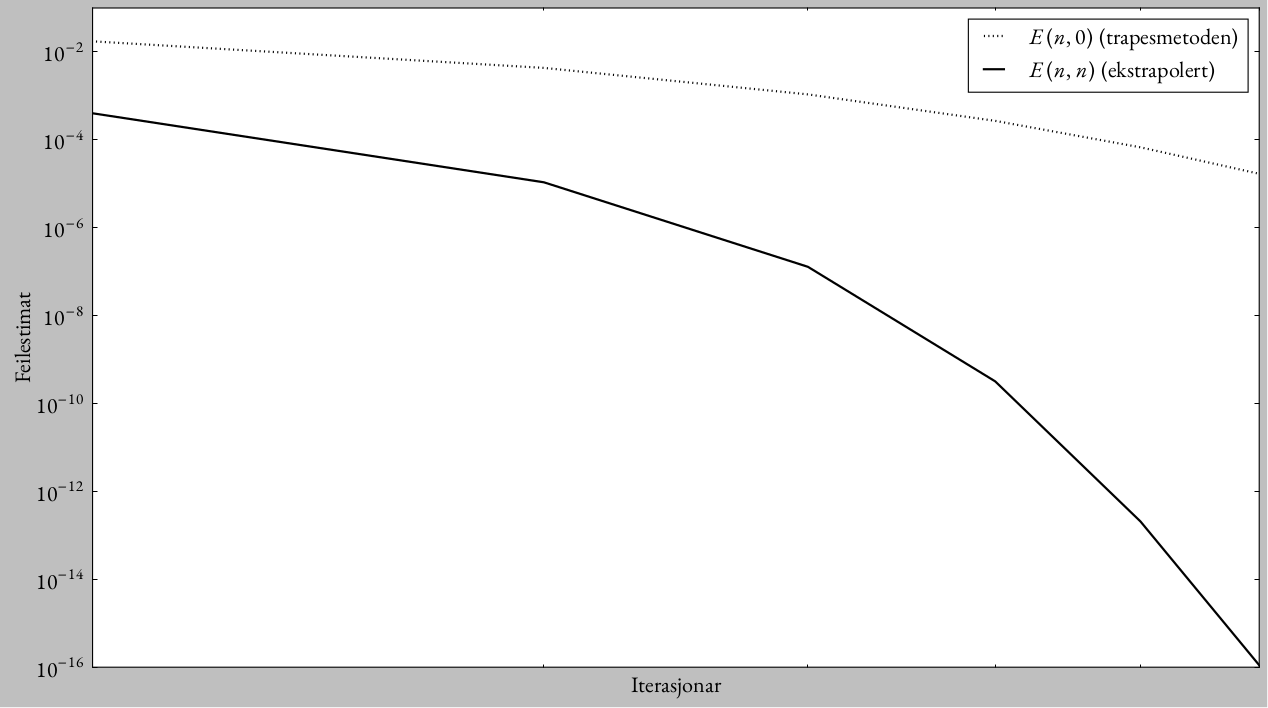

In [32]:
erf1, stats = romberg_collect_stats(gauss, 0, 1, tol=1e-16, exact=erf1_exact)

plt.plot(stats['En0'], 'k:', label="$E(n, 0)$ (trapesmetoden)")
plt.plot(stats['Enn'], 'k',  label="$E(n, n)$ (ekstrapolert)")

plt.xlabel("Iterasjonar")
plt.ylabel("Feilestimat")

plt.yscale('log')
plt.xscale('log')

plt.xlim(1, 6)

plt.xticks([])

plt.legend(loc="best")
plt.tight_layout()

plt.savefig("rom_err.pdf", bbox_inches = 'tight', pad_inches = 0)

In [22]:
np.log(len(stats['Enn']))

Avviket $E(n, 0)$ svarar til finare og finare trapes-metode-kvadraturar.
$E(n, n)$ kovergerer vesentlig raskare, fordi den brukar informasjon om dei deriverte til funksjonen.

In [13]:
3/4 - 0.7499884651404997